# Recursive Stratified Sampling of Monte Carlo Estimate

This example uses a recursive stratified sampling Monte-Carlo method to numerically integrate a function defined in Cartesian coordinates over the area of a unit circle defined in polar coordinates. 

## Author
J. Bott


## Monte-Carlo Estimate 

The estimate_polar() routine calculates the Monte-Carlo estimate for the function of polar coordinates f() over the sector of an annulus defined by boundTheta and boundR. 

## Recursive Sub-Division of Regions

The rss_polar() routine recursively combines Monte-Carlo estimates up to a maximum depth and maximum error defined by maxError and maxDepth respectively. 

At each level of recursion, the dimension with which to split the region of integration is determined such that sum of standard deviations for the function f() applied to points in each of the two sub-regions is minimized.

For two regions A and B, the number of points in each region is determined:

$$
\begin{align}
N_A &= N \frac{\sigma_A}{\sigma_A + \sigma_B} \\
N_B &= N - N_A
\end{align}
$$

Both $N_A$ and $N_B$ are adjusted to be equal to or greater than 2.


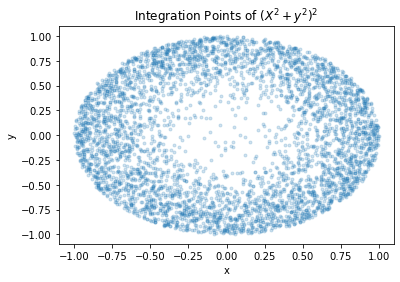

,theta,r,value,x,y
0,2.131869,0.207323,0.001848,-0.110316,0.175538
1,0.050267,0.321576,0.010694,0.321169,0.016158
2,1.311329,0.210710,0.001971,0.054061,0.203657
3,0.757602,0.327945,0.011567,0.238248,0.225358
4,2.411873,0.273651,0.005608,-0.203969,0.182432
...,...,...,...,...,...
265,3.209493,0.984728,0.940298,-0.982459,-0.066812
266,3.907500,0.995454,0.981939,-0.717477,-0.690040
267,2.061176,0.993838,0.975578,-0.468059,0.876718
268,5.703350,0.988722,0.955644,0.827118,-0.541707


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def f(theta, r):
    """ The function to integrate. """
    # Convert to rectangular coordinates
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    
    # Evaluate result
    return (x**2 + y**2)**2 

def half(t):
    """ Finds radius which divides an annulus into two equal volumes.  """
    return np.sqrt((t[1]**2)/2 + (t[0]**2)/2)


def estimate_polar(N, boundTheta, boundR, V):
    """ Monte-Carlo estimate in polar coordinates. """
    # Generate sample points
    dfPoints = pd.DataFrame(
        columns = ("theta", "r"), 
        data = np.random.uniform((boundTheta[0],boundR[0]**2), (boundTheta[1],boundR[1]**2), (N, 2)))

    # Transform R for evenly distributed density of points along radius
    dfPoints["r"] = np.sqrt(dfPoints["r"])

    # Use numpy vectorize calculation of function value 
    dfPoints["value"] = np.vectorize(f)(dfPoints["theta"], dfPoints["r"])

    #print(np.sqrt(dfPoints["value"].var()/N)*V)
    return dfPoints["value"].mean()*V \
            ,(V**2)*dfPoints["value"].var()/N \
            ,dfPoints
        
def rss_polar(N, k, boundTheta, boundR, maxError, maxDepth, depth=1):
    """ Recursive stratified sampling implementation. """
    
    # Calculate the volume of this sector of the annulus
    V = (boundR[1]**2)*(abs(boundTheta[1] - boundTheta[0])/2) - (boundR[0]**2)*(abs(boundTheta[1] - boundTheta[0])/2)
    
    # If termination criteria not met yet
    if(depth < maxDepth
      and N > 4):
        
        # Sample for estimate of variance
        dfSampleTheta1 = pd.DataFrame(
            columns = ("theta", "r"), 
            data = np.random.uniform((boundTheta[0],boundR[0]), (np.mean(boundTheta),boundR[1]), (k, 2)))
        dfSampleTheta2 = pd.DataFrame(
            columns = ("theta", "r"), 
            data = np.random.uniform((np.mean(boundTheta),boundR[0]), (boundTheta[1],boundR[1]), (k, 2)))
        dfSampleR1 = pd.DataFrame(
            columns = ("theta", "r"), 
            data = np.random.uniform((boundTheta[0],boundR[0]), (boundTheta[1],half(boundR)), (k, 2)))
        dfSampleR2 = pd.DataFrame(
            columns = ("theta", "r"), 
            data = np.random.uniform((boundTheta[0],half(boundR)), (boundTheta[1],boundR[1]), (k, 2)))
        
        # Calculate values
        dfSampleTheta1["value"] = np.vectorize(f)(dfSampleTheta1["theta"], dfSampleTheta1["r"])
        dfSampleTheta2["value"] = np.vectorize(f)(dfSampleTheta2["theta"], dfSampleTheta2["r"])
        dfSampleR1["value"] = np.vectorize(f)(dfSampleR1["theta"], dfSampleR1["r"])
        dfSampleR2["value"] = np.vectorize(f)(dfSampleR2["theta"], dfSampleR2["r"])
        
        # Calculate the combined standard error of the samples
        sample = pd.concat([dfSampleTheta1, dfSampleTheta2, dfSampleR1, dfSampleR2], axis=0)
        sampleVariance = sample["value"].var()
        errorSample = np.sqrt(sampleVariance / sample.shape[0]) * V
        
        # Error is a termination criteria
        if(errorSample <= maxError):
            valueFinal, errorFinal, dfPointsFinal = estimate_polar(N, boundTheta, boundR, V)
        else:    
            # Calculate variances
            dfSampleTheta1Variance = dfSampleTheta1["value"].var()
            dfSampleTheta2Variance = dfSampleTheta2["value"].var()
            dfSampleR1Variance = dfSampleR1["value"].var()
            dfSampleR2Variance = dfSampleR2["value"].var()
            
            # Choose the dimension to split on such that the sum of standard errors in two dimensions is reduced 
            if((np.sqrt(dfSampleTheta1Variance) + np.sqrt(dfSampleTheta2Variance)) 
               < (np.sqrt(dfSampleR1Variance) + np.sqrt(dfSampleR2Variance))):
            #if(dfSampleTheta1Variance/(4*dfSampleTheta1.shape[0]) + dfSampleTheta2Variance/(4*dfSampleTheta2.shape[0]) 
            #   < dfSampleR1Variance/(4*dfSampleR1.shape[0]) + dfSampleR2Variance/(4*dfSampleR2.shape[0])):
                # Split along Theta direction
                Na = int(N*np.sqrt(dfSampleTheta1Variance)/(np.sqrt(dfSampleTheta1Variance)+np.sqrt(dfSampleTheta2Variance)))
                Na = max(2, min(N-2, Na))
                Nb = N - Na
                #print(f"Na:{Na} Nb:{Nb}")
                valueSub1, errorSub1, dfPointsSub1 = rss_polar(Na, k, (boundTheta[0], np.mean(boundTheta)), boundR, maxError, maxDepth, depth+1)
                valueSub2, errorSub2, dfPointsSub2 = rss_polar(Nb, k, (np.mean(boundTheta), boundTheta[1]), boundR, maxError, maxDepth, depth+1)  
            else:
                # Else split along R direction
                Na = int(N*np.sqrt(dfSampleR1Variance)/(np.sqrt(dfSampleR1Variance)+np.sqrt(dfSampleR2Variance)))
                Na = max(2, min(N-2, Na))
                Nb = N - Na
                #print(f"Na:{Na} Nb:{Nb}")
                valueSub1, errorSub1, dfPointsSub1 = rss_polar(Na, k, boundTheta, (boundR[0], half(boundR)), maxError, maxDepth, depth+1)
                valueSub2, errorSub2, dfPointsSub2 = rss_polar(Nb, k, boundTheta, (half(boundR), boundR[1]), maxError, maxDepth, depth+1)
                            
            # Final estimate
            meanSub1 = dfPointsSub1["value"].mean()
            meanSub2 = dfPointsSub2["value"].mean()
            #errorFinal = np.sqrt((1/(Na+Nb-1))*((Na-1)*(errorSub1**2)+(Nb-1)*(errorSub2**2)+Na*Nb*((meanSub1-meanSub2)**2)/(Na+Nb)))
            #print(f"{errorFinal} {errorSub1} {errorSub2} {meanSub1} {meanSub2}")
            errorFinal = errorSub1/4 + errorSub2/4
            valueFinal = valueSub1 + valueSub2
            dfPointsFinal = pd.concat([dfPointsSub1, dfPointsSub2], axis=0)

    # Otherwise terminate here with a Monte-Carlo estimate of remaining points    
    else: 
        valueFinal, errorFinal, dfPointsFinal = estimate_polar(N, boundTheta, boundR, V)

    # Return final values
    return valueFinal, errorFinal, dfPointsFinal
        
# Maximum number of sample points
N = 4400
boundTheta = (0, 2*np.pi)
boundR = (0, 1)
maxError = 0.0001
maxDepth = 10

calculatedIntegral, calculatedError, df = rss_polar(N, 100, boundTheta, boundR, maxError, maxDepth)
calculatedError = np.sqrt(calculatedError)

# Transform the data
df["x"] = df["r"]*np.cos(df["theta"])
df["y"] = df["r"]*np.sin(df["theta"])

plt.scatter(df["x"], df["y"], marker='.', alpha=0.2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Integration Points of $(X^2+y^2)^2$")
plt.show()

df

In [2]:
# Analytical solution of the integral
analyticalIntegral = np.pi/3

# Print the results 
print(f"Estimate standard error: {calculatedError}")
print(f"Calculated integral: {calculatedIntegral}")
print(f"Analytical solution: {analyticalIntegral}")
print(f"Percent error is: {(100*(calculatedIntegral-analyticalIntegral)/analyticalIntegral):.4f} %")


Estimate standard error: 3.501737222698618e-05
Calculated integral: 1.0472082505010243
Analytical solution: 1.0471975511965976
Percent error is: 0.0010 %
